In [28]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [30]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

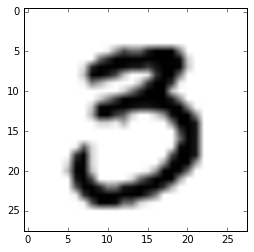

In [31]:
randomNum = random.randint(0,55000)
plt.imshow(x_train[randomNum].reshape([28,28]),cmap=plt.get_cmap('gray_r'))
plt.show()

In [32]:
def conv_2d(x,W): 
    
    # Padding : surround the original image with 0's 
    # valid padding - no padding.size of the image shrinks  resultant image : (n - f + 1, n - f + 1)
    # same padding - resultant is same as that of original. resultant image : (n + 2p - f + 1, n +2p - f + 1)  p = (f - 1)/2
    # Strides : ((n + 2p - f)/s + 1, (n +2p - f)/s + 1)
    return tf.nn.conv2d(input = x, filter = W, strides = [1,1,1,1], padding="SAME")

def avg_pool_2x2():

    # MAX/AVG Pooling : ((n + 2p - f)/s + 1, (n +2p - f)/s + 1)
    return tf.nn.avg_pool(x, k_size=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

In [33]:
def discriminator(x_image, reuse=False): 
    with tf.variable_scope('discriminator') as scope: 
        if reuse:
            tf.get_variable_scope().reuse_variables() 
        # First Conv and Pooling layers
        W_conv1 = tf.get_variable('d_wconv1',[5,5,1,8],initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1',[8],initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv_2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)
        
        # Seond Conv and Pooling layers
        W_conv2 = tf.get_variable('d_wconv2',[5,5,8,16],initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2',[16],initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv_2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)
        
        # First fully connected layers
        W_fc1 = tf.get_variable('d_wfc1', [7*7*16,32],initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool_flat = tf.reshape(h_pool2, [-1,7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat,W_fc1)+b_fc1)
        
        #Seconf fully connected layers
        W_fc2 = tf.get_variable('d_wfc2', [32,1],initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        y_conv = tf.nn.relu(tf.matmul(h_fc1,W_fc2)+b_fc2)
    
    return y_conv        

In [27]:
def generator(z,batch_size,z_dim,reuse=False):
    with tf.variable_scope('generator') as scope: 
        if reuse:
            tf.get_variable_scope().reuse_variables() 
        g_dim = 64 # num. of filters in the first layer of the generator
        c_dim = 1 # Color dimensions of the image - MNIST is grayscale
        s = 28 # output size of the image
        # Upscaling the image 
        s2, s4, s8, s16 = int(s/2),int(s/4),int(s/8),int(s/16) # upscaling the image slowly 
        h0 = tf.reshape(z, [batch_size,s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        # dimensions of h0 will be [batch_size,2,2,25]
        
        # First DeConv Layer 
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5,5,output1_shape[-1], int(h0.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides = [1,2,2,1], padding="SAME") + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs=H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        # Dimensions of H_conv1 is [batch_size, 3,3,256]
        
        # Second DeConv Layer 
        output2_shape = [batch_size, s4-1, s4-1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5,5,output2_shape[-1], int(H_conv1.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides = [1,2,2,1], padding="SAME") + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs=H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        # Dimensions of H_conv2 is [batch_size,6,6,128]
        
        # Third DeConv Layer 
        output3_shape = [batch_size, s2-2, s2-2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5,5,output3_shape[-1], int(H_conv2.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides = [1,2,2,1], padding="SAME") + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs=H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        # Dimensions of H_conv3 is [batch_size,12,12,64]
        
        # Fourth DeConv Layer 
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5,5,output4_shape[-1], int(H_conv3.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides = [1,2,2,1], padding="SAME") + b_conv4
        H_conv4 = tf.contrib.layers.batch_norm(inputs=H_conv4, center=True, scale=True, is_training=True, scope="g_bn4")
        H_conv4 = tf.nn.relu(H_conv4)
        # Dimensions of H_conv4 is [batch_size,28,28,1]
        
    return H_conv4       
        

In [20]:
sess = tf.Session()
z_dimensions = 100 
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random_normal([-1,1,[1,z_dimensions]])


ValueError: Variable generator/g_wconv1 already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()
  File "C:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
